# Classifying digits using a fully connected neural network

By REZKELLAH Fatma-Zohra

In this practical exercice a fully connected neural network (also called multi-layer perceptron) is built using keras. It is then trained to classify image digits from the MNIST database. The MNIST database is a set of 28x28 grey-level, centered images of digits.

Some baseline results:

| Method                                                                      | Test error (%) |
|-----------------------------------------------------------------------------|---------------:|
| Linear classifier (LeCun et al. 1998)                                       |           12.0 |
| K-nearest-neighbors, Euclidean (L2) (LeCun et al. 1998)                     |            5.0 |
| 3-layer NN, 500-300, softmax, cross entropy, weight decay (Hinton, 2005)    |            1.5 |
| Convolutional net LeNet-4 (LeCun et al. 1998)                               |            1.1 |
| Virtual SVM deg-9 poly [data augmentation] (LeCun et al. 1998)              |            0.8 |
| 6-layer NN with [data augmentation] (Ciresan et al. 2010)                   |           0.35 |
| Deep conv. net, 7 layers [data augmentation] (Ciresan et al. IJCAI 2011)    |           0.35 |

More results are available from: http://yann.lecun.com/exdb/mnist/

Try to improve on some of these results, at least on those that do not use data augmentation or convolutional neural networks.

Teaching assistant: romain.vo@mines-paristech.fr

## Package imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.python.keras import backend as K
from tensorflow.keras.datasets import mnist as db
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

# Magic used by the notebook to show figures inline
%matplotlib inline
# matplotlib default values
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading packages
%load_ext autoreload
%autoreload 2


## Data

The MNIST dataset is a widely used baseline for classifcation, and deep learning methods specifically, and as such is directly available through the keras API. The data is split in training and test set.

In [2]:
# Load the data
(x, y), (x_test_ori, y_test_ori) = db.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
x

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

## First look

Have a look at the data. You can run the next cell several times to have a look at different instances of the same class.

**#i** here denotes the number of samples which belongs to the class **i**.

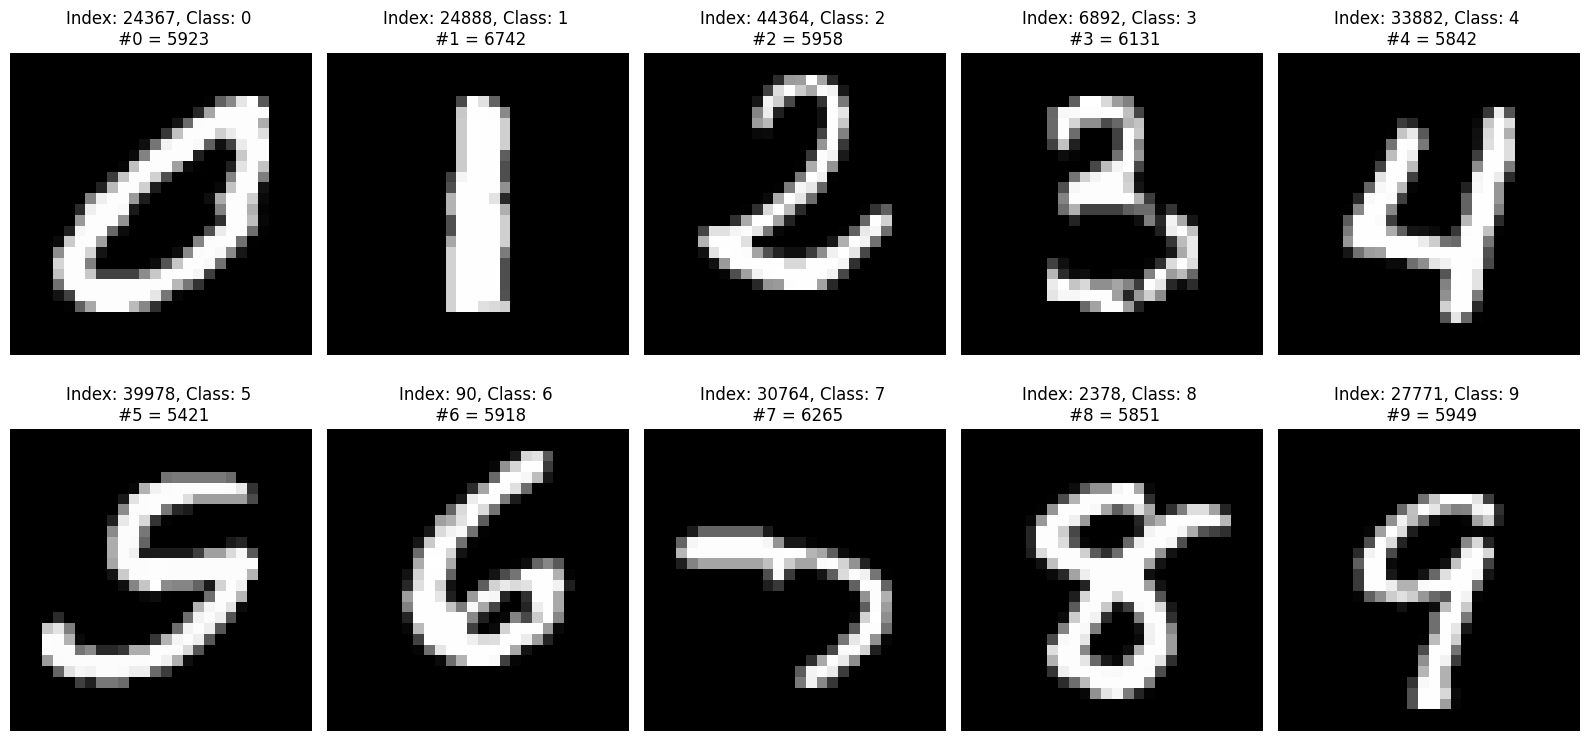

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16,8))
ax = ax.reshape(-1)

for i in range(10):
    class_mask = np.nonzero(y == i)[0]
    index = np.random.choice(class_mask)
    ax[i].imshow(x[index])
    ax[i].axis('off')
    ax[i].set_title(f"Index: {index}, Class: {y[index]} \n #{y[index]} = {class_mask.shape[0]}")

fig.tight_layout()

### Data preparation

<u>Splitting :</u> The training subset of the MNIST database contains 60000 images. We will split this set into an effective training set (90%) and a validation set (10%). This will allow us to improve our model without looking at the test set. As a rule of thumb the test should be evaluated very very few times, only when you think you have reach the end of your improvement procedure.

<u>Normalization :</u> We need to normalize the data before feeding it to the neural network, this is done simply by dividing the pixel values by 255.

<u>Formatting the input:</u> For the moment, the training data (the images) are stored in 2D arrays. Because we are using *Fully connected layers* (**FCL**), also called *Multi-Layer Perceptron* (**MLP**), we only need 1D vector as input. Thus we flatten the 2D arrays beforehand.
- `x[idx].shape = (28,28)`  $\rightarrow$  `x[idx].shape = (784)`

<u>Formatting the output:</u> For the moment, the target is simply stored by assigning to each index of the `y` array, the corresponding digit value. Here our future **MLP** will compute an `output` tensor of 10 "probabilities" (between 0 and 1) for each image. Thus for an image of the digit `8` we would like `output[7]` to be equal to 1. To learn such a network we also need to format the `y` array into a relevant encoding. So we apply a *one-hot encoding* to each value stored in `y` :
- `y[idx] = 8`  $\rightarrow$  `y[idx] = [0, 0, 0, 0, 0, 0, 0, 1, 0]`

In [5]:
# Data management
val_nb = 6000  # number of validation samples
nb_samples = x.shape[0]

if val_nb > nb_samples:
    raise ValueError("You need some samples to train your network!")

img_width, img_height = x.shape[1], x.shape[2]

num_of_pixels = img_width * img_height

# As we are using only fully connected layers, we need a vector as input
x = x.reshape(nb_samples, num_of_pixels)
x_test = x_test_ori.reshape(x_test_ori.shape[0], num_of_pixels)

# Normalization
x = x.astype('float32')
x_test = x_test.astype('float32')
x /= 255
x_test /= 255

x_val = x[:val_nb, ]
x_train = x[val_nb:, ]
y_val = y[:val_nb]
y_train = y[val_nb:]

# one-hot encoding of classes
num_classes = max(y) + 1
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test_ori, num_classes)


print(x_train.shape, 'x train samples')
print(x_val.shape, 'x val samples')
print(x_test.shape, 'x test samples')
print(y_train.shape, 'y train samples')
print(y_val.shape, 'y val samples')
print(y_test_ori.shape, 'y test samples')

(54000, 784) x train samples
(6000, 784) x val samples
(10000, 784) x test samples
(54000, 10) y train samples
(6000, 10) y val samples
(10000,) y test samples


## First model

We will begin with a network containing a single layer. We use a `softmax` activation for our last and single layer in order to normalize the `output` tensor.


In [6]:
# let define a first simple model without any hidden layers
model = Sequential()
model.add(Input(x_train.shape[1:]))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

### Training

The following section takes care of training.

Firstly, the model has to be 'compiled'. This operations lets the user to choose the loss, the optimizer and the metrics, then configures the model for training.

<u>Loss :</u> To train our model we choose a *categorical cross-entropy*, with $N$ the number of samples and $C$ the number of classes:
- $L(y, \hat{y}) = \frac{1}{N} \sum_{i=0}^N \left( - \sum_{c=1}^C y_{i,c} \log(\hat{y}_{i,c}) \right)$  

Implement a categorical cross-entropy using only `K.log`, `K.sum` , `K.mean`

To check that your implement of `categorical_crossentropy` is correct, you should approximately have the same results when setting `loss='categorical_crossentropy'`, which uses the built-in implementation of keras.

<u>Optimization :</u> Secondly, the 'fit' method runs the optimization. Training and validation data are specified here, as well as batch size and the number of epochs.


In [7]:
help(K.sum)


Help on function sum in module tensorflow.python.keras.backend:

sum(x, axis=None, keepdims=False)
    Sum of the values in a tensor, alongside the specified axis.
    
    Args:
        x: A tensor or variable.
        axis: An integer, the axis to sum over.
        keepdims: A boolean, whether to keep the dimensions or not.
            If `keepdims` is `False`, the rank of the tensor is reduced
            by 1. If `keepdims` is `True`,
            the reduced dimension is retained with length 1.
    
    Returns:
        A tensor with sum of `x`.



In [8]:
learning_rate = 0.01

def categorical_crossentropy(target, prediction):
    """
    target : array of shape [batch_size, num_classes]
    prediction : array of shape [batch_size, num_classes]
    """
    return K.mean(-K.sum(target * K.log(prediction), axis = 1), axis = 0)



model.compile(loss=categorical_crossentropy,
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])


In [9]:
model.compile(loss='categorical_crossentropy',              optimizer=SGD(learning_rate=learning_rate),          metrics=['accuracy'])

Note that you can run the cell below several times. Training will restart from the point it stopped in the previous run. However variable *output* will only contain the history of the last run.

In [10]:
batch_size = 128
epochs = 10
output = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val, y_val))

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5358 - loss: 1.7069 - val_accuracy: 0.8225 - val_loss: 0.8509
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8275 - loss: 0.8018 - val_accuracy: 0.8540 - val_loss: 0.6367
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8515 - loss: 0.6389 - val_accuracy: 0.8682 - val_loss: 0.5481
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8632 - loss: 0.5553 - val_accuracy: 0.8773 - val_loss: 0.4988
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8703 - loss: 0.5102 - val_accuracy: 0.8818 - val_loss: 0.4655
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8756 - loss: 0.4819 - val_accuracy: 0.8880 - val_loss: 0.4422
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8791 - loss: 0.4593 - val_accuracy: 0.8910 - val_loss: 0.4246
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8821 - loss: 0.4487 - val_accuracy: 

### Is training satisfactory?

Looking at the evolution of training and validation accuracies, one can evaluate the quality of training.

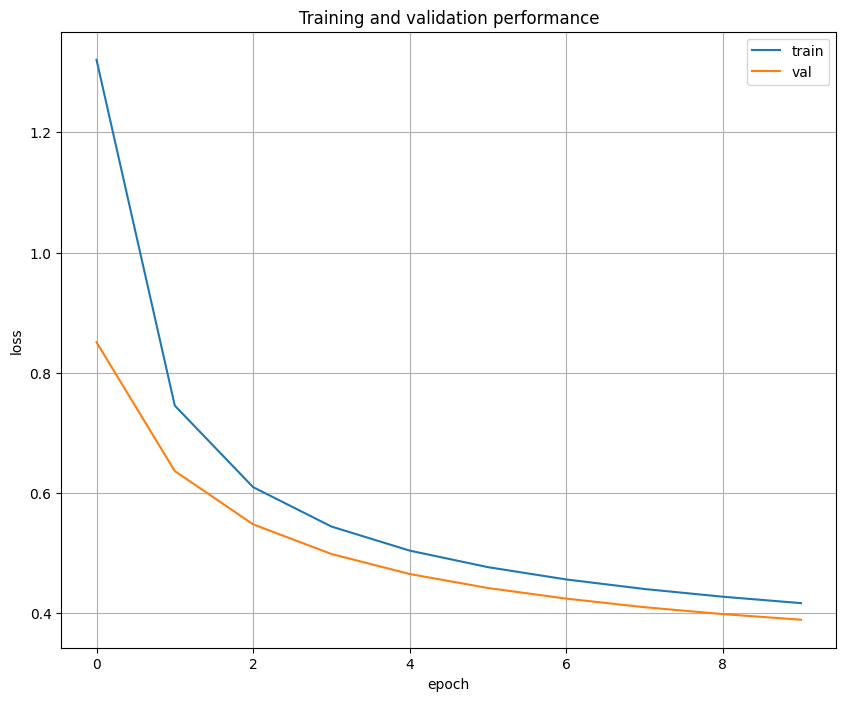

In [11]:
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()

### Questions



*   Do you think learning could be improved? Why?

**Answer**: The model can be further improved since the accuracy of the model isn't that satisfactory and compared to the models stated above we can see that the best model so far has a loss of 0.389 compared to ours which now has a loss of 0.4. The model can be further imporved by adding some extra hidden layers for the deep neural net, hypertuning some model's paramters aka, the learning rate, optimizer..

*   Is there overfitting? Why?

**Answer**: There is no overfitting, since the training and validation error have the same decreasing tendancy and are closed to each other.



In [12]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Test loss: 0.389
Test accuracy: 0.899


### Analysis of the weights

With this simple model it is possible to have an intuition of what the neural network has learned looking at
the matrix of the weights $W$.
In fact $W\in\mathbb{R}^{784\times 10}$, so for each class $i$ we can plot the weights corresponding to this class.

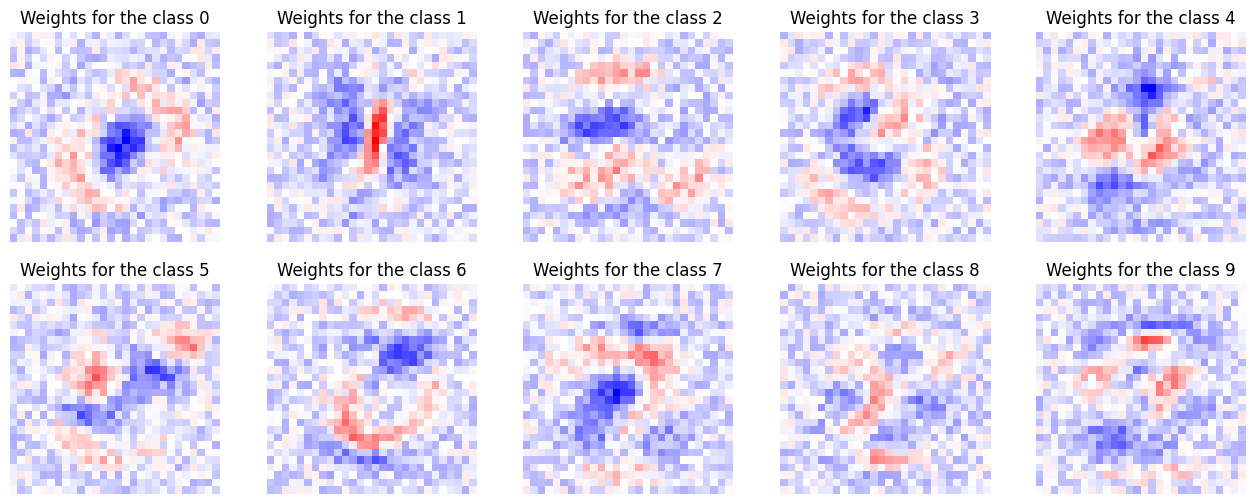

In [13]:
# plotting the weights
W, b = model.layers[0].get_weights()
vmin = W.min()
vmax = W.max()
f, ax = plt.subplots(2, 5, figsize=(16,6))
for plt_row in range(2):
    for plt_col in range(5):
        ax[plt_row][plt_col].imshow(W[:,plt_row*5 + plt_col].reshape(img_width,img_height), vmin=vmin, vmax=vmax, cmap=plt.cm.bwr)
        ax[plt_row][plt_col].axis('off')
        ax[plt_row][plt_col].set_title("Weights for the class {}".format(plt_row*5 + plt_col))
plt.show()

## Improving performance by adding extra layers

In order to improve the performances of our prediction it is possible to add hidden layers between the input layer and the output layer.

Note that here we are restricted to dense layers. Do not use (yet) other types of layers.

In [14]:
model = Sequential()
model.add(Input(x_train.shape[1:]))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax', name="last"))

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ last (Dense)                         │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
learning_rate = 0.01
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])

In [16]:
batch_size = 64
epochs = 40
output = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val, y_val),
)

Epoch 1/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5849 - loss: 1.5208 - val_accuracy: 0.8855 - val_loss: 0.4380
Epoch 2/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8826 - loss: 0.4228 - val_accuracy: 0.9080 - val_loss: 0.3259
Epoch 3/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9040 - loss: 0.3347 - val_accuracy: 0.9210 - val_loss: 0.2843
Epoch 4/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9173 - loss: 0.2923 - val_accuracy: 0.9288 - val_loss: 0.2577
Epoch 5/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9236 - loss: 0.2674 - val_accuracy: 0.9355 - val_loss: 0.2364
Epoch 6/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9309 - loss: 0.2446 - val_accuracy: 0.9390 - val_loss: 0.2238
Epoch 7/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9352 - loss: 0.2264 - val_accuracy: 0.9452 - val_loss: 0.2072
Epoch 8/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9402 - loss: 0.2104 - val_accuracy: 0.

### Analysis of the results




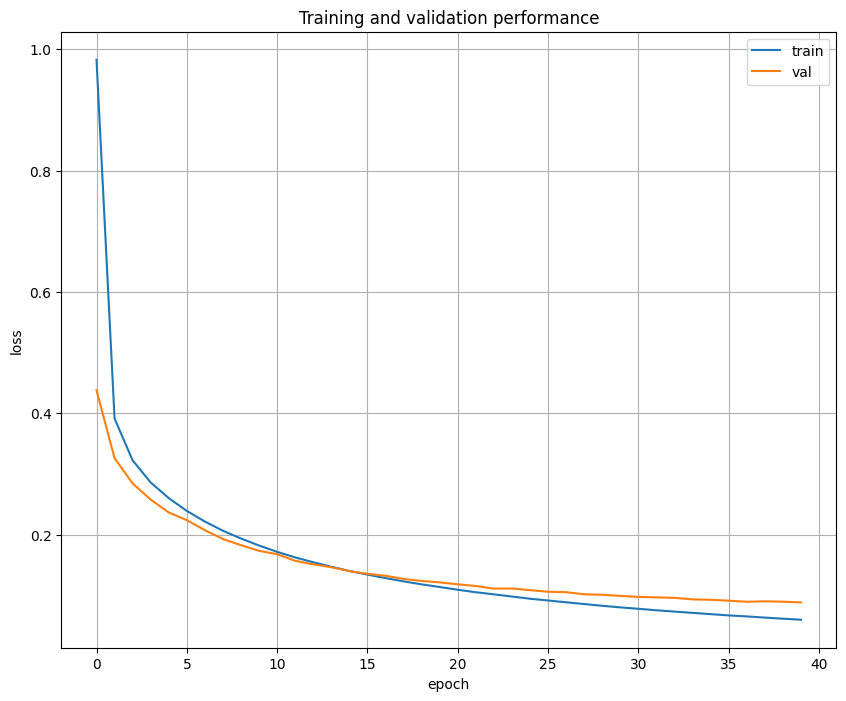

In [17]:
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()
# plt.ylim(0.2, 0.8)

Is there overfitting? How can it be reduced?

**Answer**:
- The model started to overfit in this case. As at first the val loss curve was under the training loss which means the model was able to generalize. However at a certain point; the training loss decreases more significantly than the val loss which went greater than the training loss which means that the model overfit on the training data and started to perform poorly on unseen data.

- This can be reduced using various techniques such as Data augmentation, regularization, batch normalization or using dropout technqiues in the Deep neural net

In [18]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Test loss: 0.087
Test accuracy: 0.972


### Qualitative error analysis

Let us have a look at some images that have been incorrectly classified.

<u>Inference </u>: We call the `predict` method on our model and feed the `x_test` array to obtain the probabilities for each test sample. The `y_predict_proba` is a *one-hot encoded* array so we compute the index of the maximum predicted probability to extract the label of the predicted digit

In [19]:
y_predict_proba = model.predict(x_test)
y_predict = np.argmax(y_predict_proba, 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


You can run the following cell several times to inspect different errors, or manually change the `index` variable

In [20]:
rng = np.random.default_rng(0)

Correct label is: 1
Predicted label is: 8 with a "probability" of 86.74%
Label 1 was predicted with a "probability" of 6.17%

Probabilities: [2.5530206e-04 6.1742488e-02 8.7628534e-05 1.6295344e-02 3.7295013e-05
 1.0233472e-05 2.9313571e-06 3.6871205e-03 8.6735016e-01 5.0531447e-02]


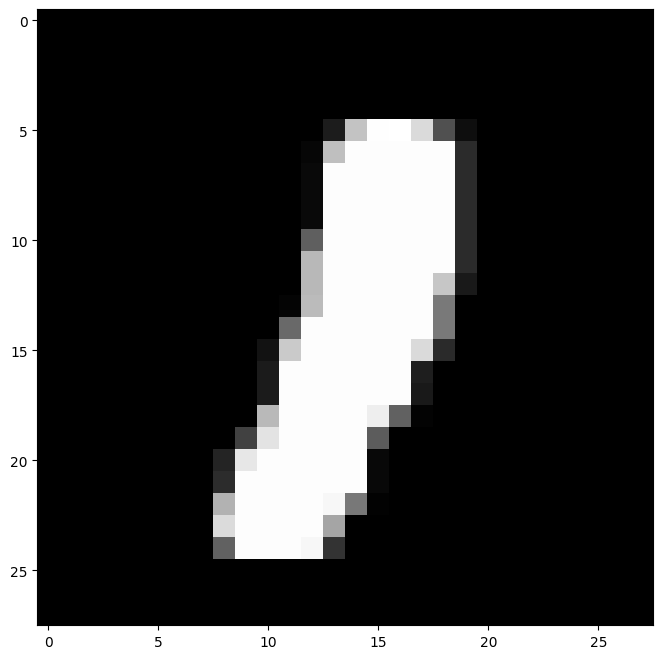

In [21]:
err_mask = y_test_ori != y_predict
ok_mask = y_test_ori == y_predict

x_test_errors = x_test_ori[err_mask]
y_test_errors = y_test_ori[err_mask]
y_predict_errors = y_predict[err_mask]
y_predict_proba_errors = y_predict_proba[err_mask]
y_predict_proba_ok = y_predict_proba[ok_mask]

index = rng.choice(range(y_test_errors.shape[0]))
print(f"Correct label is: { y_test_errors[index]}")
print(f"Predicted label is: {y_predict_errors[index]} with a \"probability\" of {y_predict_proba_errors[index, y_predict_errors[index]]:.2%}")
print(f"Label {y_test_errors[index]} was predicted with a \"probability\" of {y_predict_proba_errors[index, y_test_errors[index]]:.2%}", end='\n\n')
print(f"Probabilities: {y_predict_proba_errors[index]}")
plt.imshow(x_test_errors[index], cmap="gray")
plt.show()

We can plot the histogram of the probabilities of the predicted classes, given that the predictions are correct or incorrect. This should give us some intuitions on how the network "behaves" during inference

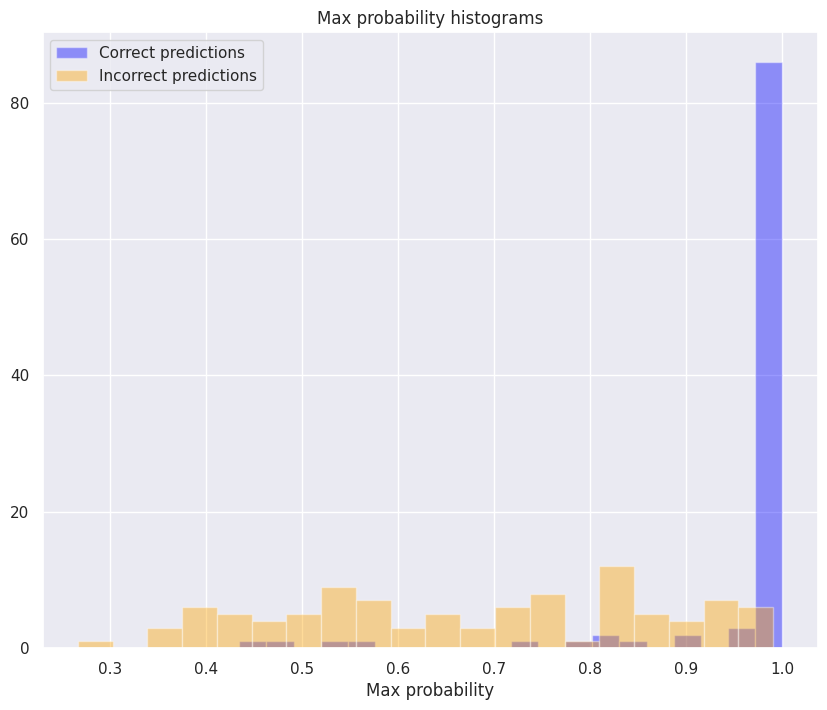

In [22]:
%matplotlib inline

# p.max() keeps the highest probability among the 10 outputs.

max_predictions_correct = np.max(y_predict_proba[ok_mask], 1)
max_predictions_incorrect = np.max(y_predict_proba[err_mask], 1)

# np.random.shuffle shuffles the values of the array
np.random.shuffle(max_predictions_correct)
np.random.shuffle(max_predictions_incorrect)

y_predict_proba_errors.shape

histo_bins = 20
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots()

ax.hist(max_predictions_correct[0:100], density=False,
         bins=histo_bins,
         color="blue",
         alpha=0.4,
         label='Correct predictions')
ax.hist(max_predictions_incorrect[0:100],density=False,
         bins=histo_bins,
         color="orange",
         alpha=0.4,
         label='Incorrect predictions')

ax.set_title('Max probability histograms')
ax.set_xlabel("Max probability")
ax.legend()

sns.reset_defaults()


Is the network 'confident' when making errors?

**Answer**:
We observe that when the model's predictions are correct, the maximum probabilities are close to 1. This suggests that when the model is confident, it tends to make correct predictions. When the model's predictions are incorrect, the probabilities are spread across a wider range (0 to 1). This implies that the model is less confident in these predictions, and in cases where the model is unsure, it is more likely to make mistakes.

What do you think about these errors?

**Answer**:
The model appears to be confident when it is correct, as reflected by the high probabilities (close to 1).
However, when the model is uncertain or unsure, as shown by the more spread-out probabilities, it tends to make incorrect predictions.
This is a healthy behavior for a model since it shows that the model is not "overconfident" when it is wrong.


### Quantitative error analysis

We can measure the uncertainty of our model by measuring the entropy of its predictions. In [information theory](https://en.wikipedia.org/wiki/Entropy_(information_theory)) the entropy of a random variable is given by $H(X) = - \sum_{x \in \mathcal{X}} p(x) \log\left(p(x)\right)$. In our case we can compute the entropy of a prediction using:
- $H(\hat{y}) = - \sum_{c=1}^C \hat{y}_{c} \log(\hat{y}_{c})$

In [23]:
def entropy(predictions):
    return - np.sum(predictions * np.log(predictions), axis=1)

We will plot the smoothed histogram (Kernel Density Estimation) of our predictions' entropy, given that the predictions are correct or incorrect.

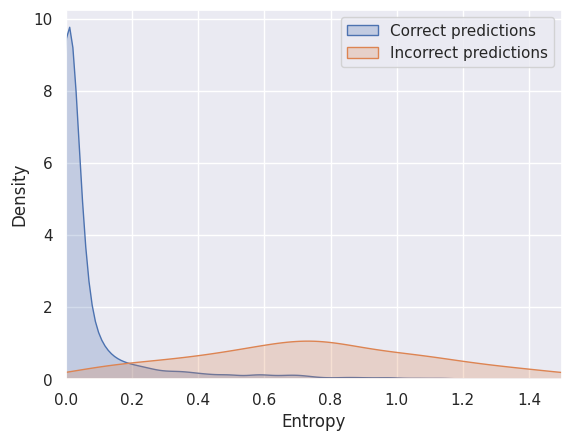

In [24]:
%matplotlib inline
sns.set_theme()

entropies = entropy(y_predict_proba)

fig, ax = plt.subplots()
sns.kdeplot(entropies[ok_mask], label='Correct predictions', ax=ax, fill=True)
sns.kdeplot(entropies[err_mask], label='Incorrect predictions',ax=ax, fill=True)
ax.set_xlim(0, 1.5)
ax.set_xlabel('Entropy')

ax.legend()

sns.reset_defaults()

From this plot what can you say about our model in terms of uncertainty ? Why ?

**Answer**:
We observe that when the model's predictions are correct, the entropy is close to zero and it's low meaning the uncertainty of the model is low.
When the model's predictions are incorrect, the uncertainty goes higher. This implies that the model is less confident in these predictions, and in cases where the model is unsure, it is more likely to make mistakes.

Very quickly, What kind of prediction would maximize the entropy ?

**Answer**: y = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] in the case where the model gives all the classes equal probilbilties, the value of uncertainty goes really high as the model is unsure on which class it should predict finally

Based on the analysis of the entropy, design a procedure to estimate beforehand if a prediction will be wrong or not.

What are the limits of your procedure ? You could surely use the following objects do analyze the limits: `entropies, err_mask, ok_mask`

You could use the following objects: `entropies, err_mask, ok_mask`

**Answer**:
Uncertainty ≠ Incorrectness: High entropy means the model is uncertain, but this does not guarantee that the prediction will be wrong. There may still be cases where the model is uncertain but makes a correct prediction.

Low Entropy ≠ Correctness: Conversely, low entropy may suggest high confidence, but the model could still be confidently wrong in some cases.

Entropy Threshold Selection: The choice of the threshold
 is critical. Setting it too high may miss incorrect predictions, while setting it too low may falsely flag correct predictions as incorrect.

In [25]:
def estimate_prediction_correctness(entropies, entropy_threshold):

    err_mask = entropies > entropy_threshold
    ok_mask = entropies <= entropy_threshold

    return entropies, err_mask, ok_mask

### Analysing the last layer

Each neuron $i$ in the last layer of the network corresponds to one class. Its weights $W_i$ can be interpreted as the parameters of a hyperplane $H_i$ of $R^d$, where $d$ is the number of neurons of the previous layer.

If two classes are correctly separated by the network, one can expect that the two corresponding hyperplanes are orthogonal. This can be evaluated by calculating the cosine between their normal vectors. This measure is called.... cosine similarity.

Note that as $d$ increases, the expected value of the cosine of two random normal vectors of $R^d$ converges towards zero. Put otherwise: in high dimension, two random vectors tend to be orthogonal.

Shape of the weights array: (128, 10)


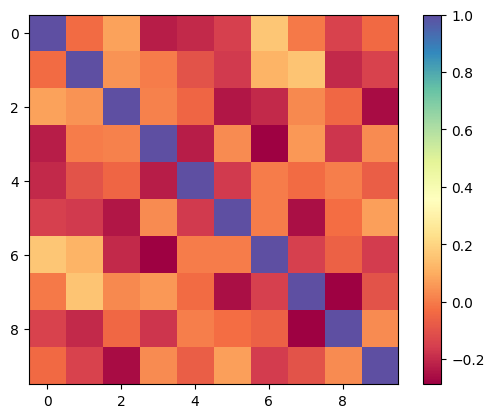

In [26]:
weights, bias = model.get_layer("last").get_weights()
print("Shape of the weights array:", weights.shape)
norms = []
for neuron in range(weights.shape[1]):
    norms += [np.linalg.norm(weights[:,neuron])]
weights /= norms

cos = np.matmul(weights.transpose(), weights)

plt.imshow(cos)
plt.set_cmap('Spectral')
plt.colorbar()
plt.show()

In [27]:
print(cos)

[[ 1.0000001  -0.03288172  0.07599278 -0.22356068 -0.19950551 -0.151175
   0.16411696 -0.00459552 -0.14254305 -0.03895883]
 [-0.03288172  0.9999998   0.04715787  0.00380365 -0.09986709 -0.16324265
   0.1164184   0.15835877 -0.19798304 -0.14263257]
 [ 0.07599278  0.04715787  0.99999994  0.01214276 -0.0487869  -0.23830363
  -0.20084614  0.02485581 -0.04614317 -0.26193404]
 [-0.22356068  0.00380365  0.01214276  1.0000001  -0.22452866  0.03226373
  -0.28777722  0.05830556 -0.17544563  0.03223105]
 [-0.19950551 -0.09986709 -0.0487869  -0.22452866  0.9999998  -0.16468798
   0.00333661 -0.03164569  0.00446391 -0.06885207]
 [-0.151175   -0.16324265 -0.23830363  0.03226373 -0.16468798  1.0000001
   0.00357105 -0.25348338 -0.02744667  0.07439262]
 [ 0.16411696  0.1164184  -0.20084614 -0.28777722  0.00333661  0.00357105
   1.         -0.14874583 -0.05861202 -0.1578583 ]
 [-0.00459552  0.15835877  0.02485581  0.05830556 -0.03164569 -0.25348338
  -0.14874583  0.99999994 -0.28695834 -0.09795044]
 [-

Which classes seem to be the most correlated? Would you have expected this?

**Answer**:
Most Correlated Classes:
Class 1 and Class 7: The correlation between these classes is 0.158, which is relatively higher than the others.
Class 0 and Class 6: The correlation is 0.164, showing a positive relationship.

Most Anti-Correlated Classes:
Class 6 and Class 3: The correlation between these classes is -0.287, indicating a strong anti-correlation.
Class 8 and Class 7: With a value of -0.287, this shows strong anti-correlation.
Class 9 and Class 2: The correlation here is -0.261, also pointing to a significant negative relationship.

The classes that are positively correlated (e.g., 1 and 7, 0 and 6) indicate that the features learned by the model overlap somewhat for these classes. It means the model finds similarities between them.
The classes that are negatively correlated (e.g., 6 and 3, 8 and 7) have distinct features that the model clearly differentiates between.


 Some correlations may be expected. For example, class 1 and class 7 might be correlated because both contain some straight line elements in their shapes (e.g., the vertical line in "1" and the vertical parts of "7"). Similarly, class 0 and class 6 share a circular shape, which might explain the positive correlation.

### Improving your network

Try to improve the performance of your network: try different numbers of layers (do not use convolutional layers yet), as well as the number of neurons per layer.

What is your best validation accuracy?

**Answer**: The best validation accuracy is 0.9770

In [28]:
from tensorflow.keras.layers import Dropout

model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(784,)))  # First hidden layer
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))  # Second hidden layer
model.add(Dense(32, activation='relu'))  # Third hidden layer
model.add(Dense(10, activation='softmax'))  # Output layer

model.summary()

learning_rate = 0.01
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])

batch_size = 64
epochs = 40
output = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val, y_val),
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,146 (434.16 KB)

 Trainable params: 111,146 (434.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4712 - loss: 1.6295 - val_accuracy: 0.8777 - val_loss: 0.4532
Epoch 2/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8532 - loss: 0.4946 - val_accuracy: 0.9147 - val_loss: 0.3160
Epoch 3/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8901 - loss: 0.3799 - val_accuracy: 0.9278 - val_loss: 0.2675
Epoch 4/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9043 - loss: 0.3264 - val_accuracy: 0.9355 - val_loss: 0.2371
Epoch 5/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9161 - loss: 0.2880 - val_accuracy: 0.9418 - val_loss: 0.2133
Epoch 6/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9240 - loss: 0.2550 - val_accuracy: 0.9470 - val_loss: 0.1909
Epoch 7/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9313 - loss: 0.2369 - val_accuracy: 0.9517 - val_loss: 0.1770
Epoch 8/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9360 - loss: 0.2182 - val_accuracy: 0.

### Testing

Testing is the last stage of the learning process. Good practice recommends to do it only once, when you have completely finished with the optimization of the network parameters and hyperparameters.

In [29]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Test loss: 0.076
Test accuracy: 0.977


### Confusion matrix

Each value $C_{i,j}$ of the confusion matrix $C$ gives the number of elements known to belong to class $i$ that have been classified in class $j$.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


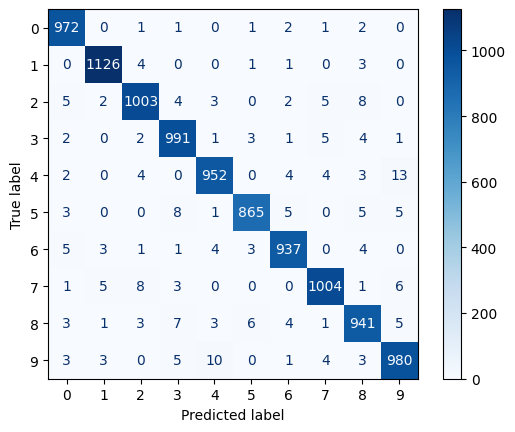

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_proba = model.predict(x_test)
y_pred = y_pred_proba.argmax(axis=-1)

ConfusionMatrixDisplay.from_predictions(y_test_ori, y_pred, cmap=plt.cm.Blues)
plt.show()

Which pair of classes causes the most confusion? Is it coherent with the analysis of the cosine similarity between neurons of the last layer? Why?

**Answer**: The one that causes the most confusion is (4,9) with 13 misidentified examples, also in teh pair (2,8) we do have the second worst confusion with 8 misidentified examples.
It's not coherent with the cosine similarity between neurons of the last layer.

 while the cosine similarity gives insight into how similar the model perceives the feature representations of different classes, the confusion matrix reveals actual misclassification behavior, which can be influenced by other factors like visual similarities and model limitations. The two analyses complement each other but highlight different aspects of model performance and class relationships.

## Using Convolutional Layers

In order experiment with convolutional networks and see their benefits, we can now use convolutional layers.

<u>Formatting input: </u>: since we are going to use convolutional layers we need image data. We can map images back to their original domain in a 28 x 28 grid

In [34]:
x_train_2d = x_train.reshape([-1,28,28,1])
x_val_2d = x_val.reshape([-1,28,28,1])
x_test_2d = x_test.reshape([-1,28,28,1])

Here we will implement our first convolutional neural network. Using keras `Sequential` API, build a CNN with the following sequential architecture:

        - Conv2D: 16 filters and a kernel of size (5x5), ReLU activation
        - MaxPooling2D
        - Conv2D: 32 filters and a kernel of size (3x3), ReLU activation
        - MaxPooling2D
        - Conv2D: 32 filters and a kernel of size (3x3), ReLU activation
        - MLP: 128 neurons, ReLU activation
        - MLP: num_classes neurons
        - Softmax activation

Dont forget, we are now working with images but the MLP layers only takes 1D vector as input.

Use `help(Conv2D)`, etc.. directly in a cell to access the layers API or directly check on [keras](https://keras.io/api/)

In [35]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()


model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)))  # Assuming grayscale images of size 28x28
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))


model.add(Flatten())

model.add(Dense(128, activation='relu'))


num_classes = 10
model.add(Dense(num_classes, activation='softmax'))

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 24, 24, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,586 (205.41 KB)

 Trainable params: 52,586 (205.41 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
learning_rate = 0.01
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])

In [37]:
batch_size = 64
epochs = 40
output = model.fit(x_train_2d, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val_2d, y_val),
)

Epoch 1/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3971 - loss: 1.7979 - val_accuracy: 0.9083 - val_loss: 0.3051
Epoch 2/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9079 - loss: 0.3006 - val_accuracy: 0.9483 - val_loss: 0.1795
Epoch 3/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9461 - loss: 0.1793 - val_accuracy: 0.9630 - val_loss: 0.1238
Epoch 4/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9609 - loss: 0.1314 - val_accuracy: 0.9710 - val_loss: 0.1006
Epoch 5/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9692 - loss: 0.1011 - val_accuracy: 0.9727 - val_loss: 0.0906
Epoch 6/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9746 - loss: 0.0832 - val_accuracy: 0.9762 - val_loss: 0.0771
Epoch 7/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9773 - loss: 0.0746 - val_accuracy: 0.9778 - val_loss: 0.0694
Epoch 8/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9792 - loss: 0.0678 - val_accuracy: 0.

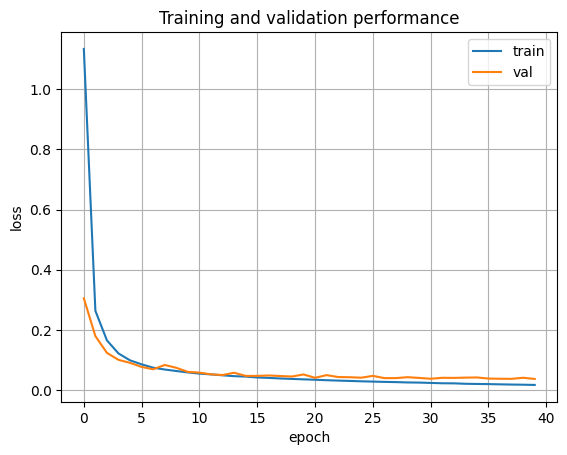

In [38]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()
# plt.ylim(0.2, 0.8)

Is it overfitting? What can you say about it when you compare with the denser architecture?
What else can you do to reduce it?

**Answer:**
The model does not show clear signs of overfitting, as both training and validation losses are low and relatively close, along with high accuracy metrics, but in order to make sure the model doesn't overfit we can use dropout layers, regularization..

In [39]:
score = model.evaluate(x_test_2d, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Test loss: 0.031
Test accuracy: 0.990


# Visualizing the Feature Maps

We can try to understand what is happening in the network by looking at its feature maps. Since they are defined on a grid, we can vizualize them as images.

Here we vizualize the feature maps of the first layer for some images.

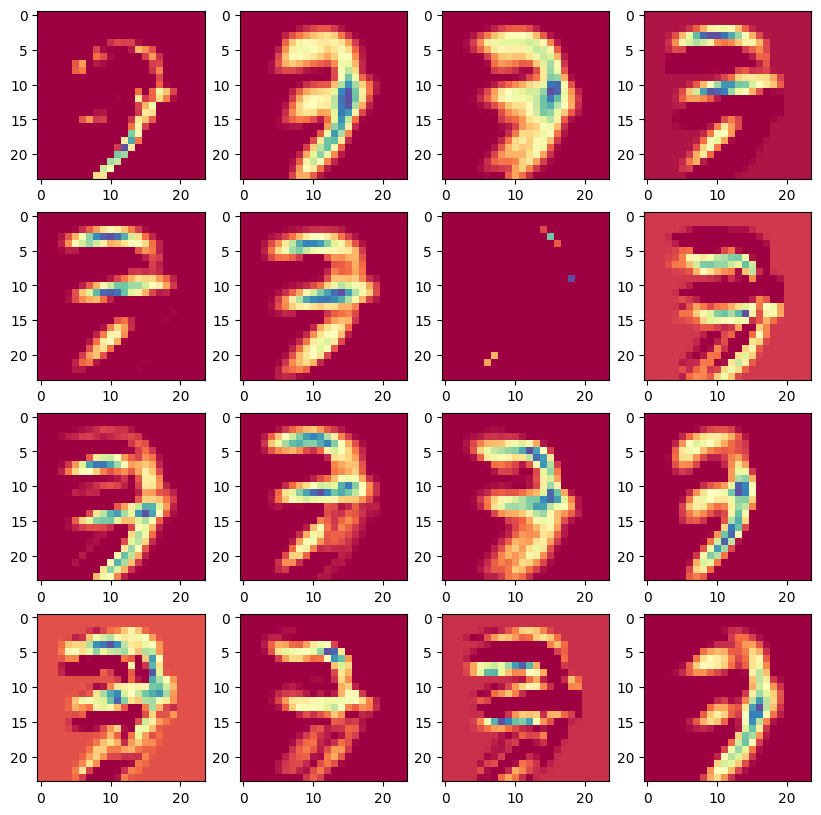

In [40]:
%matplotlib inline

im = x_test_2d[np.random.randint(0, x_test_2d.shape[0]), :, :, :]
im = im[np.newaxis, ...]
fmaps = model.layers[0](im)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(fmaps[0,:,:,i])

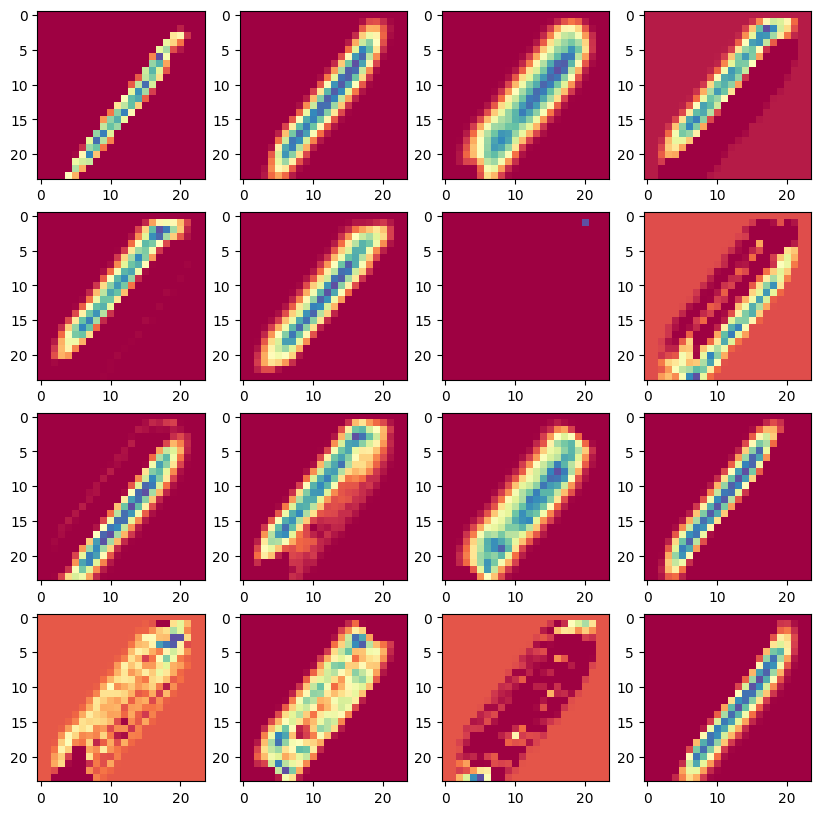

In [41]:
%matplotlib inline

im = x_test_2d[np.random.randint(0, x_test_2d.shape[0]), :, :, :]
im = im[np.newaxis, ...]
fmaps = model.layers[0](im)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(fmaps[0,:,:,i])

Can you identify if the convolutional layer detects meaningful features?(for example edges and corners)

**Answer:** from the feature map, some areas manifest as high-contrast areas where pixel intensity changes sharply. we can features resembling straight lines or corners, which indicates that the CNN is effectively detecting these fundamental elements of the images.

# Improving your network

As before, try to improve your network by changing the number of layers of each type and the number of feature maps, neurons or kernel size.

In [42]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D())
model.add(BatchNormalization())

# Convolutional Layer 2
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())

# Convolutional Layer 3
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())

# Global Average Pooling or Flattening
model.add(GlobalAveragePooling2D())  # or use model.add(Flatten())

# Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout to reduce overfitting
model.add(Dense(num_classes, activation='softmax'))

model.summary()

learning_rate = 0.01
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])

batch_size = 64
epochs = 40
output = model.fit(x_train_2d, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val_2d, y_val),
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12, 12, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 5, 5, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 1, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129,674 (506.54 KB)

 Trainable params: 129,226 (504.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8178 - loss: 0.6169 - val_accuracy: 0.9752 - val_loss: 0.0924
Epoch 2/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9655 - loss: 0.1206 - val_accuracy: 0.9823 - val_loss: 0.0648
Epoch 3/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9752 - loss: 0.0848 - val_accuracy: 0.9842 - val_loss: 0.0570
Epoch 4/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9803 - loss: 0.0681 - val_accuracy: 0.9827 - val_loss: 0.0585
Epoch 5/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9836 - loss: 0.0571 - val_accuracy: 0.9868 - val_loss: 0.0481
Epoch 6/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9852 - loss: 0.0494 - val_accuracy: 0.9875 - val_loss: 0.0453
Epoch 7/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9874 - loss: 0.0430 - val_accuracy: 0.9880 - val_loss: 0.0435
Epoch 8/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9879 - loss: 0.0392 - val_accuracy: 0


What is your best validation accuracy?

**Answer**: it's 0.9913

# Optional: Experimenting with a more complex database

We will now move to the fashion MNIST database, in order to experiment with a more complex database. The best test accuracy reported on this database is 0.967 (see https://github.com/zalandoresearch/fashion-mnist).



In [ ]:
from tensorflow.keras.datasets import fashion_mnist as db

# You can use the following dictionary to transform number labels into meaningful labels:
fashion_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
    }

print(fashion_dict[2])

In [ ]:
# Load and have a look at the data
(x, y), (x_test_ori, y_test_ori) = db.load_data()

# Visualize a single digit, with its class
plt_r,plt_c = 4,4
f, ax = plt.subplots(plt_r, plt_c, figsize=(16,16))
for i in range(plt_r):
    for j in range(plt_c):
        index = np.random.randint(x.shape[0])
        ax[i][j].imshow(x[index], cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title("Example: {}, Class: {}".format(index, y[index]))
plt.show()

Build your own model below, train it on the fashion MNIST database and analyse its results. Dont forget to normalize and put the data into the correct format. Try to reach the highest validation accuracy. Finally, evaluate it using the test database.

You must respect the following constraints:

* you can use dense, convolutional, and pooling layers in your network;

* do not change the optimizer, the loss or the metrics used during training.



In [ ]:
# Your code comes here. You can use several cells.

In [ ]:
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid
plt.show()
# plt.ylim(0.2, 0.8)

# Your results on the fashion MNIST database

Which pairs of classes are the main cause of confusion?

**Answer**: ...


Did you use an architecture different than the one used for MNIST? If so, how?

**Answer**: ...


Is there overfitting?

**Answer**: ...

**Test accuracy**: ...